# Tiny-YOLO Object Detection on Pascal VOC

This notebook implements a Tiny-YOLO architecture from scratch using PyTorch, trained on the Pascal VOC dataset using CUDA.

In [9]:
# Install required packages
import subprocess
import sys

packages = ['torch', 'torchvision', 'numpy', 'matplotlib', 'tqdm', 'opencv-python']
for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import cv2
import os

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# ============================================
# RTX 4090 OPTIMIZATIONS
# ============================================

# Enable cuDNN auto-tuner for optimal convolution algorithms
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Enable TF32 for faster matrix multiplications on Ampere/Ada GPUs
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Set float32 matmul precision to high for better performance
torch.set_float32_matmul_precision('high')

print("\n✓ RTX 4090 Optimizations Enabled:")
print("  - cuDNN benchmark mode")
print("  - TF32 tensor cores")
print("  - High precision matmul")

Using device: cuda
GPU: NVIDIA GeForce RTX 4090
CUDA Version: 12.8
VRAM: 23.5 GB

✓ RTX 4090 Optimizations Enabled:
  - cuDNN benchmark mode
  - TF32 tensor cores
  - High precision matmul


## Configuration Parameters

In [11]:
# Tiny-YOLO Configuration - OPTIMIZED FOR RTX 4090 (24GB VRAM)
IMAGE_SIZE = 416          # Input image size
GRID_SIZE = 13            # Output grid size (416/32)
NUM_CLASSES = 80          # COCO has 80 classes
NUM_ANCHORS = 5           # Number of anchor boxes per grid cell

# ============================================
# RTX 4090 OPTIMIZED SETTINGS (Anti-Overfitting)
# ============================================
BATCH_SIZE = 32           # Smaller batch = more regularization, better generalization
NUM_WORKERS = 8           # More workers for faster data loading
LEARNING_RATE = 1e-4      # Lower LR for more stable training
NUM_EPOCHS = 100          # Total epochs
WARMUP_EPOCHS = 3         # Warmup period
PATIENCE = 15             # Early stopping patience

# Loss weights - Prioritize IoU
LAMBDA_COORD = 5.0        # Weight for coordinate loss
LAMBDA_NOOBJ = 0.5        # Weight for no-object loss
LAMBDA_IOU = 2.0          # Weight for IoU loss (NEW - prioritize IoU)

# Regularization
DROPOUT_RATE = 0.3        # Dropout for regularization
WEIGHT_DECAY = 5e-4       # L2 regularization

# Data Augmentation
USE_AUGMENTATION = True   # Enable data augmentation
AUG_HSV_H = 0.015         # Hue augmentation
AUG_HSV_S = 0.7           # Saturation augmentation  
AUG_HSV_V = 0.4           # Value augmentation
AUG_FLIP_P = 0.5          # Horizontal flip probability
AUG_SCALE = (0.8, 1.2)    # Random scale range

# Mixed Precision Training (FP16)
USE_AMP = True            # Automatic Mixed Precision for ~2x speedup

# COCO Classes (80 classes)
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# COCO category ID to continuous index mapping (COCO IDs are not continuous)
COCO_CAT_IDS = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
    43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
    62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84,
    85, 86, 87, 88, 89, 90
]
COCO_CAT_ID_TO_IDX = {cat_id: idx for idx, cat_id in enumerate(COCO_CAT_IDS)}

# Anchor boxes (width, height) - normalized to grid cell
ANCHORS = torch.tensor([
    [1.08, 1.19],
    [3.42, 4.41],
    [6.63, 11.38],
    [9.42, 5.11],
    [16.62, 10.52]
]).to(device)

print(f"RTX 4090 Optimized Configuration (IoU-Focused, Anti-Overfitting):")
print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Batch Size: {BATCH_SIZE} (smaller for better generalization)")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Dropout Rate: {DROPOUT_RATE}")
print(f"  IoU Loss Weight: {LAMBDA_IOU}")
print(f"  Data Augmentation: {USE_AUGMENTATION}")
print(f"  Early Stopping Patience: {PATIENCE} epochs")
print(f"  Dataset: COCO ({NUM_CLASSES} classes)")

RTX 4090 Optimized Configuration (IoU-Focused, Anti-Overfitting):
  Image Size: 416x416
  Batch Size: 32 (smaller for better generalization)
  Learning Rate: 0.0001
  Weight Decay: 0.0005
  Dropout Rate: 0.3
  IoU Loss Weight: 2.0
  Data Augmentation: True
  Early Stopping Patience: 15 epochs
  Dataset: COCO (80 classes)


## Tiny-YOLO Architecture (Layer by Layer)

In [22]:
class ConvBlock(nn.Module):
    """Convolutional block: Conv2d + BatchNorm + LeakyReLU"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1, inplace=True)
    
    def forward(self, x):
        return self.leaky(self.bn(self.conv(x)))


class TinyYOLO(nn.Module):
    """
    Tiny-YOLO Architecture with Dropout Regularization
    
    The network consists of:
    - 9 convolutional layers with batch normalization
    - 5 max pooling layers (stride 2) + 1 max pooling layer (stride 1)
    - Dropout layers for regularization (prevents overfitting)
    - Final detection layer
    """
    
    def __init__(self, num_classes=20, num_anchors=5, dropout_rate=0.3):
        super(TinyYOLO, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.dropout_rate = dropout_rate
        
        # Layer 0: Input (3 channels) -> 16 filters
        self.conv1 = ConvBlock(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 416 -> 208
        
        # Layer 1: 16 -> 32 filters
        self.conv2 = ConvBlock(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 208 -> 104
        
        # Layer 2: 32 -> 64 filters
        self.conv3 = ConvBlock(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 104 -> 52
        
        # Layer 3: 64 -> 128 filters
        self.conv4 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 52 -> 26
        
        # Layer 4: 128 -> 256 filters
        self.conv5 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)  # 26 -> 13
        
        # Dropout after deep layers
        self.dropout1 = nn.Dropout2d(p=dropout_rate)
        
        # Layer 5: 256 -> 512 filters
        self.conv6 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pad6 = nn.ZeroPad2d((0, 1, 0, 1))
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.dropout2 = nn.Dropout2d(p=dropout_rate)
        
        # Layer 6: 512 -> 1024 filters
        self.conv7 = ConvBlock(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        
        self.dropout3 = nn.Dropout2d(p=dropout_rate)
        
        # Layer 7: 1024 -> 256 filters
        self.conv8 = ConvBlock(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding=0)
        
        # Layer 8: 256 -> 512 filters
        self.conv9 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        # Detection Layer
        self.detection = nn.Conv2d(
            in_channels=512, 
            out_channels=num_anchors * (5 + num_classes), 
            kernel_size=1, stride=1, padding=0
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        x = self.pool5(self.conv5(x))
        x = self.dropout1(x)
        
        x = self.pool6(self.pad6(self.conv6(x)))
        x = self.dropout2(x)
        
        x = self.conv7(x)
        x = self.dropout3(x)
        
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.detection(x)
        return x

# Create model with dropout
model = TinyYOLO(num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS, dropout_rate=DROPOUT_RATE).to(device)

print("Tiny-YOLO Architecture (with Dropout Regularization):")
print("=" * 60)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print("=" * 60)

# Test forward pass
test_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
test_output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
assert test_output.shape == (1, NUM_ANCHORS * (5 + NUM_CLASSES), GRID_SIZE, GRID_SIZE)
print("✓ Output shape verified!")

Tiny-YOLO Architecture (with Dropout Regularization):
Total parameters: 7,955,769
Dropout Rate: 0.3
Input shape: torch.Size([1, 3, 416, 416])
Output shape: torch.Size([1, 425, 13, 13])
✓ Output shape verified!


## COCO Dataset Loader

In [23]:
import os
import json
import random
from PIL import Image, ImageEnhance
from pycocotools.coco import COCO

# Dataset path
DATASET_PATH = '~/korino/arm/training/coco_data'
DATASET_PATH_EXPANDED = os.path.expanduser(DATASET_PATH)

print(f"Dataset directory: {DATASET_PATH}")

# Verify dataset exists
train_images_path = os.path.join(DATASET_PATH_EXPANDED, 'train2017')
annotations_path = os.path.join(DATASET_PATH_EXPANDED, 'annotations')

if os.path.exists(train_images_path) and os.path.exists(annotations_path):
    print(f"✓ Found train2017 images")
    print(f"✓ Found annotations")
else:
    raise FileNotFoundError(f"COCO dataset not found at {DATASET_PATH_EXPANDED}")

ANCHORS_CPU = torch.tensor([
    [1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]
])


class COCODatasetAugmented(Dataset):
    """
    COCO Dataset with Data Augmentation for YOLO training
    
    Augmentations:
    - Random horizontal flip (50%)
    - HSV color jitter (brightness, saturation, contrast)
    - Random scale (80%-120%)
    """
    
    def __init__(self, root, image_set='train', year='2017',
                 image_size=416, grid_size=13, num_classes=80, num_anchors=5, 
                 anchors=None, augment=False):
        self.root = os.path.expanduser(root)
        self.image_size = image_size
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.anchors = anchors.cpu() if anchors.is_cuda else anchors
        self.augment = augment
        
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        ann_file = os.path.join(self.root, 'annotations', f'instances_{image_set}{year}.json')
        print(f"Loading annotations from: {ann_file}")
        self.coco = COCO(ann_file)
        
        self.image_ids = [img_id for img_id in self.coco.imgs.keys() 
                         if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        self.images_dir = os.path.join(self.root, f'{image_set}{year}')
        
        print(f"Loaded {len(self.image_ids)} images | Augmentation: {'ON' if augment else 'OFF'}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def augment_hsv(self, img):
        """HSV color augmentation"""
        if random.random() < 0.5:
            img = ImageEnhance.Brightness(img).enhance(1.0 + random.uniform(-AUG_HSV_V, AUG_HSV_V))
        if random.random() < 0.5:
            img = ImageEnhance.Color(img).enhance(1.0 + random.uniform(-AUG_HSV_S, AUG_HSV_S))
        if random.random() < 0.5:
            img = ImageEnhance.Contrast(img).enhance(1.0 + random.uniform(-0.3, 0.3))
        return img
    
    def horizontal_flip(self, img, bboxes):
        """Flip image and bboxes horizontally"""
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        w = img.size[0]
        return img, [[w - x - bw, y, bw, h, cat] for x, y, bw, h, cat in bboxes]
    
    def random_scale(self, img, bboxes, scale_range=(0.8, 1.2)):
        """Random scale augmentation"""
        orig_w, orig_h = img.size
        scale = random.uniform(*scale_range)
        new_w, new_h = int(orig_w * scale), int(orig_h * scale)
        img = img.resize((new_w, new_h), Image.BILINEAR)
        
        if scale > 1.0:  # Crop
            left = random.randint(0, new_w - orig_w)
            top = random.randint(0, new_h - orig_h)
            img = img.crop((left, top, left + orig_w, top + orig_h))
            bboxes = [[x * scale - left, y * scale - top, w * scale, h * scale, cat] 
                      for x, y, w, h, cat in bboxes]
        else:  # Pad
            padded = Image.new('RGB', (orig_w, orig_h), (128, 128, 128))
            left, top = (orig_w - new_w) // 2, (orig_h - new_h) // 2
            padded.paste(img, (left, top))
            img = padded
            bboxes = [[x * scale + left, y * scale + top, w * scale, h * scale, cat] 
                      for x, y, w, h, cat in bboxes]
        
        # Filter valid bboxes
        bboxes = [[x, y, w, h, cat] for x, y, w, h, cat in bboxes 
                  if x + w > 0 and y + h > 0 and x < orig_w and y < orig_h and w > 2 and h > 2]
        return img, bboxes
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img = Image.open(os.path.join(self.images_dir, img_info['file_name'])).convert('RGB')
        orig_w, orig_h = img.size
        
        # Get bboxes
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
        bboxes = []
        for ann in anns:
            if ann.get('iscrowd', 0) or ann['category_id'] not in COCO_CAT_ID_TO_IDX:
                continue
            x, y, w, h = ann['bbox']
            if w > 0 and h > 0:
                bboxes.append([x, y, w, h, ann['category_id']])
        
        # Apply augmentation
        if self.augment and len(bboxes) > 0:
            img = self.augment_hsv(img)
            if random.random() < AUG_FLIP_P:
                img, bboxes = self.horizontal_flip(img, bboxes)
            if random.random() < 0.5:
                img, bboxes = self.random_scale(img, bboxes, AUG_SCALE)
        
        aug_w, aug_h = img.size
        
        # Resize and normalize
        img = img.resize((self.image_size, self.image_size), Image.BILINEAR)
        img = self.normalize(transforms.ToTensor()(img))
        
        # Create target tensor
        target = torch.zeros(self.grid_size, self.grid_size, self.num_anchors, 5 + self.num_classes)
        
        for x, y, w, h, cat_id in bboxes:
            class_idx = COCO_CAT_ID_TO_IDX[cat_id]
            
            x_center = (x + w / 2) / aug_w
            y_center = (y + h / 2) / aug_h
            width = w / aug_w
            height = h / aug_h
            
            x_center = min(max(x_center, 0), 0.999)
            y_center = min(max(y_center, 0), 0.999)
            
            grid_x = int(x_center * self.grid_size)
            grid_y = int(y_center * self.grid_size)
            grid_x = min(max(grid_x, 0), self.grid_size - 1)
            grid_y = min(max(grid_y, 0), self.grid_size - 1)
            
            # Find best anchor
            box_wh = torch.tensor([width * self.grid_size, height * self.grid_size])
            best_anchor = 0
            best_iou = 0
            for a_idx, anchor in enumerate(self.anchors):
                inter = min(box_wh[0], anchor[0]) * min(box_wh[1], anchor[1])
                union = box_wh[0] * box_wh[1] + anchor[0] * anchor[1] - inter
                iou = inter / (union + 1e-6)
                if iou > best_iou:
                    best_iou, best_anchor = iou, a_idx
            
            if target[grid_y, grid_x, best_anchor, 4] == 0:
                target[grid_y, grid_x, best_anchor, 0] = x_center * self.grid_size - grid_x
                target[grid_y, grid_x, best_anchor, 1] = y_center * self.grid_size - grid_y
                target[grid_y, grid_x, best_anchor, 2] = width * self.grid_size
                target[grid_y, grid_x, best_anchor, 3] = height * self.grid_size
                target[grid_y, grid_x, best_anchor, 4] = 1.0
                target[grid_y, grid_x, best_anchor, 5 + class_idx] = 1.0
        
        return img, target


# Create datasets
print(f"\nLoading COCO datasets...")

train_dataset = COCODatasetAugmented(
    root=DATASET_PATH, image_set='train', year='2017',
    image_size=IMAGE_SIZE, grid_size=GRID_SIZE,
    num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS, anchors=ANCHORS_CPU,
    augment=USE_AUGMENTATION  # AUGMENTATION ON for training
)

val_images_path = os.path.join(DATASET_PATH_EXPANDED, 'val2017')
val_ann_path = os.path.join(DATASET_PATH_EXPANDED, 'annotations', 'instances_val2017.json')

if os.path.exists(val_images_path) and os.path.exists(val_ann_path):
    val_dataset = COCODatasetAugmented(
        root=DATASET_PATH, image_set='val', year='2017',
        image_size=IMAGE_SIZE, grid_size=GRID_SIZE,
        num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS, anchors=ANCHORS_CPU,
        augment=False  # NO augmentation for validation
    )
else:
    print("⚠ val2017 not found, splitting training data")
    full_dataset = COCODatasetAugmented(
        root=DATASET_PATH, image_set='train', year='2017',
        image_size=IMAGE_SIZE, grid_size=GRID_SIZE,
        num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS, anchors=ANCHORS_CPU,
        augment=False
    )
    train_size = len(full_dataset) - 5000
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, 5000], generator=torch.Generator().manual_seed(42)
    )

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, 
                          persistent_workers=True, prefetch_factor=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, 
                        persistent_workers=True, prefetch_factor=4)

print(f"\n✓ Dataset loaded!")
print(f"  Training: {len(train_dataset)} samples | Augmentation: {USE_AUGMENTATION}")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Batches/epoch: {len(train_loader)}")

Dataset directory: ~/korino/arm/training/coco_data
✓ Found train2017 images
✓ Found annotations

Loading COCO datasets...
Loading annotations from: /home/researchadmin/korino/arm/training/coco_data/annotations/instances_train2017.json
loading annotations into memory...
Done (t=20.32s)
creating index...
index created!
Loaded 117266 images | Augmentation: ON
Loading annotations from: /home/researchadmin/korino/arm/training/coco_data/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Loaded 4952 images | Augmentation: OFF

✓ Dataset loaded!
  Training: 117266 samples | Augmentation: True
  Validation: 4952 samples
  Batches/epoch: 3664


## YOLO Loss Function

In [24]:
def compute_ciou(pred_boxes, target_boxes, eps=1e-7):
    """
    Complete IoU (CIoU) - Directly optimizes IoU, center distance, and aspect ratio
    
    CIoU = IoU - (center_distance² / diagonal²) - α*v
    where v measures aspect ratio consistency
    """
    pred_cx, pred_cy = pred_boxes[:, 0], pred_boxes[:, 1]
    pred_w, pred_h = pred_boxes[:, 2].clamp(min=eps), pred_boxes[:, 3].clamp(min=eps)
    
    target_cx, target_cy = target_boxes[:, 0], target_boxes[:, 1]
    target_w, target_h = target_boxes[:, 2].clamp(min=eps), target_boxes[:, 3].clamp(min=eps)
    
    # Convert to corners
    pred_x1, pred_y1 = pred_cx - pred_w/2, pred_cy - pred_h/2
    pred_x2, pred_y2 = pred_cx + pred_w/2, pred_cy + pred_h/2
    target_x1, target_y1 = target_cx - target_w/2, target_cy - target_h/2
    target_x2, target_y2 = target_cx + target_w/2, target_cy + target_h/2
    
    # Intersection
    inter_x1 = torch.max(pred_x1, target_x1)
    inter_y1 = torch.max(pred_y1, target_y1)
    inter_x2 = torch.min(pred_x2, target_x2)
    inter_y2 = torch.min(pred_y2, target_y2)
    inter_area = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
    
    # Union
    pred_area = pred_w * pred_h
    target_area = target_w * target_h
    union_area = pred_area + target_area - inter_area + eps
    
    # IoU
    iou = inter_area / union_area
    
    # Enclosing box diagonal
    enclose_x1 = torch.min(pred_x1, target_x1)
    enclose_y1 = torch.min(pred_y1, target_y1)
    enclose_x2 = torch.max(pred_x2, target_x2)
    enclose_y2 = torch.max(pred_y2, target_y2)
    enclose_diag_sq = (enclose_x2 - enclose_x1)**2 + (enclose_y2 - enclose_y1)**2 + eps
    
    # Center distance
    center_dist_sq = (pred_cx - target_cx)**2 + (pred_cy - target_cy)**2
    
    # Aspect ratio term
    v = (4 / (torch.pi**2)) * (torch.atan(pred_w/(pred_h+eps)) - torch.atan(target_w/(target_h+eps)))**2
    
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)
    
    ciou = iou - center_dist_sq / enclose_diag_sq - alpha * v
    return ciou


class YOLOLossWithCIoU(nn.Module):
    """
    YOLO Loss with CIoU for better bounding box regression
    
    CIoU directly optimizes:
    1. IoU (overlap)
    2. Center distance  
    3. Aspect ratio consistency
    
    Much better than MSE for object detection!
    """
    
    def __init__(self, num_classes=80, num_anchors=5, anchors=None, 
                 lambda_coord=5.0, lambda_noobj=0.5, lambda_iou=2.0, label_smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.anchors = anchors
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.lambda_iou = lambda_iou
        self.label_smoothing = label_smoothing
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='sum')
    
    def forward(self, predictions, targets):
        batch_size = predictions.size(0)
        grid_size = predictions.size(2)
        
        # Reshape: (B, A, 5+C, G, G) -> (B, G, G, A, 5+C)
        predictions = predictions.view(batch_size, self.num_anchors, 5 + self.num_classes, grid_size, grid_size)
        predictions = predictions.permute(0, 3, 4, 1, 2).contiguous()
        
        pred_xy = torch.sigmoid(predictions[..., :2])
        pred_wh = predictions[..., 2:4]
        pred_conf = predictions[..., 4]
        pred_class = predictions[..., 5:]
        
        target_xy = targets[..., :2]
        target_wh = targets[..., 2:4]
        target_conf = targets[..., 4]
        target_class = targets[..., 5:]
        
        obj_mask = target_conf == 1
        noobj_mask = target_conf == 0
        
        ciou_loss = torch.tensor(0.0, device=predictions.device)
        avg_iou = 0.0
        
        if obj_mask.sum() > 0:
            # Create grid
            grid_y, grid_x = torch.meshgrid(
                torch.arange(grid_size, device=predictions.device),
                torch.arange(grid_size, device=predictions.device), indexing='ij'
            )
            grid_x = grid_x.float().unsqueeze(-1).expand_as(pred_xy[..., 0])
            grid_y = grid_y.float().unsqueeze(-1).expand_as(pred_xy[..., 1])
            
            # Predicted boxes (absolute grid coords)
            pred_cx = (pred_xy[..., 0] + grid_x)[obj_mask]
            pred_cy = (pred_xy[..., 1] + grid_y)[obj_mask]
            
            anchor_w = self.anchors[:, 0].view(1, 1, 1, -1).expand_as(pred_wh[..., 0])
            anchor_h = self.anchors[:, 1].view(1, 1, 1, -1).expand_as(pred_wh[..., 1])
            
            pred_w = (anchor_w * torch.exp(pred_wh[..., 0].clamp(max=10)))[obj_mask]
            pred_h = (anchor_h * torch.exp(pred_wh[..., 1].clamp(max=10)))[obj_mask]
            
            # Target boxes
            target_cx = (target_xy[..., 0] + grid_x)[obj_mask]
            target_cy = (target_xy[..., 1] + grid_y)[obj_mask]
            target_w = target_wh[..., 0][obj_mask]
            target_h = target_wh[..., 1][obj_mask]
            
            pred_boxes = torch.stack([pred_cx, pred_cy, pred_w, pred_h], dim=-1)
            target_boxes = torch.stack([target_cx, target_cy, target_w, target_h], dim=-1)
            
            ciou = compute_ciou(pred_boxes, target_boxes)
            avg_iou = ciou.mean().item()
            ciou_loss = self.lambda_iou * (1 - ciou).sum()
        
        # Confidence loss
        conf_loss = torch.tensor(0.0, device=predictions.device)
        if obj_mask.sum() > 0:
            conf_loss += self.bce_loss(pred_conf[obj_mask], target_conf[obj_mask])
        if noobj_mask.sum() > 0:
            conf_loss += self.lambda_noobj * self.bce_loss(pred_conf[noobj_mask], target_conf[noobj_mask])
        
        # Class loss with label smoothing
        class_loss = torch.tensor(0.0, device=predictions.device)
        if obj_mask.sum() > 0:
            # Apply label smoothing
            smoothed_targets = target_class[obj_mask] * (1 - self.label_smoothing) + self.label_smoothing / self.num_classes
            class_loss = self.bce_loss(pred_class[obj_mask], smoothed_targets)
        
        total_loss = (ciou_loss + conf_loss + class_loss) / batch_size
        
        return total_loss, {
            'ciou_loss': ciou_loss.item() / batch_size,
            'conf_loss': conf_loss.item() / batch_size,
            'class_loss': class_loss.item() / batch_size,
            'avg_iou': avg_iou
        }


# Initialize CIoU loss
criterion = YOLOLossWithCIoU(
    num_classes=NUM_CLASSES,
    num_anchors=NUM_ANCHORS,
    anchors=ANCHORS,
    lambda_coord=LAMBDA_COORD,
    lambda_noobj=LAMBDA_NOOBJ,
    lambda_iou=LAMBDA_IOU,
    label_smoothing=0.1  # Helps with classification
)

print("✓ YOLO Loss with CIoU initialized")
print(f"  λ_iou: {LAMBDA_IOU} (prioritizes IoU)")
print(f"  λ_noobj: {LAMBDA_NOOBJ}")
print(f"  Label smoothing: 0.1")

✓ YOLO Loss with CIoU initialized
  λ_iou: 2.0 (prioritizes IoU)
  λ_noobj: 0.5
  Label smoothing: 0.1


## Training Loop with CUDA

In [25]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, device, epoch):
    """Train one epoch with IoU tracking"""
    model.train()
    total_loss = 0
    total_iou = 0
    loss_components = {'ciou_loss': 0, 'conf_loss': 0, 'class_loss': 0}
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=USE_AMP):
            predictions = model(images)
            loss, components = criterion(predictions, targets)
        
        if USE_AMP:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        scheduler.step()
        
        total_loss += loss.item()
        total_iou += components.get('avg_iou', 0)
        for k in loss_components:
            loss_components[k] += components.get(k, 0)
        
        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'IoU': f'{components.get("avg_iou", 0):.3f}'})
    
    n = len(train_loader)
    return total_loss/n, {k: v/n for k, v in loss_components.items()}, total_iou/n


def validate(model, val_loader, criterion, device):
    """Validate with IoU tracking"""
    model.eval()
    total_loss = 0
    total_iou = 0
    loss_components = {'ciou_loss': 0, 'conf_loss': 0, 'class_loss': 0}
    
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc='Validating'):
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=USE_AMP):
                predictions = model(images)
                loss, components = criterion(predictions, targets)
            
            total_loss += loss.item()
            total_iou += components.get('avg_iou', 0)
            for k in loss_components:
                loss_components[k] += components.get(k, 0)
    
    n = len(val_loader)
    return total_loss/n, {k: v/n for k, v in loss_components.items()}, total_iou/n


class EarlyStopping:
    """Stop training when validation loss stops improving"""
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        self.counter += 1
        return self.counter >= self.patience


# Optimizer with stronger regularization
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,  # Stronger L2 regularization
    betas=(0.9, 0.999),
    fused=True
)

# Scheduler with warmup
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE * 10,
    total_steps=NUM_EPOCHS * len(train_loader),
    pct_start=WARMUP_EPOCHS / NUM_EPOCHS,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100
)

scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.01)

# Compile model
if hasattr(torch, 'compile'):
    print("Compiling model with torch.compile()...")
    model = torch.compile(model, mode='reduce-overhead')

print(f"\n✓ Training Setup (Anti-Overfitting):")
print(f"  Optimizer: AdamW (weight_decay={WEIGHT_DECAY})")
print(f"  Early Stopping: patience={PATIENCE}")
print(f"  Dropout: {DROPOUT_RATE}")
print(f"  Data Augmentation: {USE_AUGMENTATION}")

Compiling model with torch.compile()...

✓ Training Setup (Anti-Overfitting):
  Optimizer: AdamW (weight_decay=0.0005)
  Early Stopping: patience=15
  Dropout: 0.3
  Data Augmentation: True


In [26]:
# Main training loop - IoU Optimized with Anti-Overfitting
print("=" * 70)
print("🚀 IoU-Optimized Training with Anti-Overfitting Measures")
print("=" * 70)
print("Improvements Applied:")
print("  ✓ CIoU Loss - Directly optimizes IoU, center distance, aspect ratio")
print("  ✓ Data Augmentation - Flip, HSV jitter, random scale")
print("  ✓ Dropout (30%) - Regularization in deep layers")
print("  ✓ Label Smoothing - Better classification generalization")
print("  ✓ Early Stopping - Prevents overfitting")
print("  ✓ Weight Decay - L2 regularization")
print("=" * 70)

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

train_losses, val_losses = [], []
train_ious, val_ious = [], []
best_val_loss = float('inf')
best_val_iou = 0

import time
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    train_loss, train_comp, train_iou = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, scaler, device, epoch
    )
    val_loss, val_comp, val_iou = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    
    epoch_time = time.time() - epoch_start
    lr = optimizer.param_groups[0]['lr']
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} [{epoch_time:.1f}s]")
    print(f"  Train - Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | CIoU: {train_comp['ciou_loss']:.3f}")
    print(f"  Val   - Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | CIoU: {val_comp['ciou_loss']:.3f}")
    print(f"  LR: {lr:.2e} | Gap Ratio: {val_loss/(train_loss+1e-6):.2f}x")
    
    # Save best by loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'val_loss': val_loss, 'val_iou': val_iou
        }, 'tiny_yolo_best.pth')
        print(f"  ✓ Saved best model (loss: {val_loss:.4f})")
    
    # Save best by IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'val_iou': val_iou
        }, 'tiny_yolo_best_iou.pth')
        print(f"  ✓ Saved best IoU model (IoU: {val_iou:.4f})")
    
    # Early stopping
    if early_stopping(val_loss):
        print(f"\n⚠ Early stopping at epoch {epoch+1} - val loss hasn't improved for {PATIENCE} epochs")
        break

total_time = time.time() - start_time
print("\n" + "=" * 70)
print("🎉 Training Complete!")
print(f"  Time: {total_time/60:.1f} min | Epochs: {len(train_losses)}")
print(f"  Best Val Loss: {best_val_loss:.4f}")
print(f"  Best Val IoU: {best_val_iou:.4f}")
print("=" * 70)

🚀 IoU-Optimized Training with Anti-Overfitting Measures
Improvements Applied:
  ✓ CIoU Loss - Directly optimizes IoU, center distance, aspect ratio
  ✓ Data Augmentation - Flip, HSV jitter, random scale
  ✓ Dropout (30%) - Regularization in deep layers
  ✓ Label Smoothing - Better classification generalization
  ✓ Early Stopping - Prevents overfitting
  ✓ Weight Decay - L2 regularization


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:07<00:00, 21.56it/s]



Epoch 1/100 [183.1s]
  Train - Loss: 67.0945 | IoU: 0.3925 | CIoU: 7.626
  Val   - Loss: 52.9877 | IoU: 0.4172 | CIoU: 7.486
  LR: 3.25e-04 | Gap Ratio: 0.79x
  ✓ Saved best model (loss: 52.9877)
  ✓ Saved best IoU model (IoU: 0.4172)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.60it/s]



Epoch 2/100 [164.9s]
  Train - Loss: 50.9759 | IoU: 0.4235 | CIoU: 7.239
  Val   - Loss: 50.0998 | IoU: 0.4430 | CIoU: 7.166
  LR: 7.75e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 50.0998)
  ✓ Saved best IoU model (IoU: 0.4430)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.36it/s]



Epoch 3/100 [165.2s]
  Train - Loss: 48.1573 | IoU: 0.4408 | CIoU: 7.029
  Val   - Loss: 47.1107 | IoU: 0.4594 | CIoU: 6.959
  LR: 1.00e-03 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 47.1107)
  ✓ Saved best IoU model (IoU: 0.4594)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.18it/s]



Epoch 4/100 [164.8s]
  Train - Loss: 45.9657 | IoU: 0.4530 | CIoU: 6.877
  Val   - Loss: 44.6811 | IoU: 0.4670 | CIoU: 6.864
  LR: 1.00e-03 | Gap Ratio: 0.97x
  ✓ Saved best model (loss: 44.6811)
  ✓ Saved best IoU model (IoU: 0.4670)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.39it/s]



Epoch 5/100 [165.1s]
  Train - Loss: 44.5344 | IoU: 0.4601 | CIoU: 6.786
  Val   - Loss: 43.6061 | IoU: 0.4721 | CIoU: 6.795
  LR: 9.99e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 43.6061)
  ✓ Saved best IoU model (IoU: 0.4721)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.96it/s]



Epoch 6/100 [164.7s]
  Train - Loss: 43.5848 | IoU: 0.4647 | CIoU: 6.729
  Val   - Loss: 42.8622 | IoU: 0.4766 | CIoU: 6.739
  LR: 9.98e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 42.8622)
  ✓ Saved best IoU model (IoU: 0.4766)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.23it/s]



Epoch 7/100 [164.6s]
  Train - Loss: 42.8563 | IoU: 0.4682 | CIoU: 6.687
  Val   - Loss: 42.0902 | IoU: 0.4816 | CIoU: 6.675
  LR: 9.96e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 42.0902)
  ✓ Saved best IoU model (IoU: 0.4816)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.04it/s]



Epoch 8/100 [164.5s]
  Train - Loss: 42.3199 | IoU: 0.4713 | CIoU: 6.648
  Val   - Loss: 41.6281 | IoU: 0.4825 | CIoU: 6.667
  LR: 9.93e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 41.6281)
  ✓ Saved best IoU model (IoU: 0.4825)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.63it/s]



Epoch 9/100 [165.8s]
  Train - Loss: 41.8493 | IoU: 0.4733 | CIoU: 6.620
  Val   - Loss: 41.3887 | IoU: 0.4855 | CIoU: 6.627
  LR: 9.91e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 41.3887)
  ✓ Saved best IoU model (IoU: 0.4855)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.38it/s]



Epoch 10/100 [165.5s]
  Train - Loss: 41.5045 | IoU: 0.4754 | CIoU: 6.594
  Val   - Loss: 40.7544 | IoU: 0.4910 | CIoU: 6.559
  LR: 9.87e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 40.7544)
  ✓ Saved best IoU model (IoU: 0.4910)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.91it/s]



Epoch 11/100 [166.3s]
  Train - Loss: 41.1669 | IoU: 0.4771 | CIoU: 6.573
  Val   - Loss: 40.4269 | IoU: 0.4913 | CIoU: 6.556
  LR: 9.83e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 40.4269)
  ✓ Saved best IoU model (IoU: 0.4913)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:04<00:00, 31.08it/s]



Epoch 12/100 [165.9s]
  Train - Loss: 40.9082 | IoU: 0.4784 | CIoU: 6.556
  Val   - Loss: 40.1366 | IoU: 0.4942 | CIoU: 6.518
  LR: 9.79e-04 | Gap Ratio: 0.98x
  ✓ Saved best model (loss: 40.1366)
  ✓ Saved best IoU model (IoU: 0.4942)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.79it/s]



Epoch 13/100 [166.1s]
  Train - Loss: 40.6720 | IoU: 0.4799 | CIoU: 6.539
  Val   - Loss: 40.0991 | IoU: 0.4941 | CIoU: 6.519
  LR: 9.74e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 40.0991)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.74it/s]



Epoch 14/100 [166.2s]
  Train - Loss: 40.4045 | IoU: 0.4810 | CIoU: 6.522
  Val   - Loss: 39.8161 | IoU: 0.4964 | CIoU: 6.489
  LR: 9.69e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 39.8161)
  ✓ Saved best IoU model (IoU: 0.4964)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.87it/s]



Epoch 15/100 [166.8s]
  Train - Loss: 40.2062 | IoU: 0.4818 | CIoU: 6.512
  Val   - Loss: 39.8242 | IoU: 0.4966 | CIoU: 6.488
  LR: 9.63e-04 | Gap Ratio: 0.99x
  ✓ Saved best IoU model (IoU: 0.4966)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.65it/s]



Epoch 16/100 [166.3s]
  Train - Loss: 40.0690 | IoU: 0.4829 | CIoU: 6.502
  Val   - Loss: 39.7384 | IoU: 0.4975 | CIoU: 6.477
  LR: 9.56e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 39.7384)
  ✓ Saved best IoU model (IoU: 0.4975)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.53it/s]



Epoch 17/100 [166.5s]
  Train - Loss: 39.8987 | IoU: 0.4838 | CIoU: 6.489
  Val   - Loss: 39.3737 | IoU: 0.4991 | CIoU: 6.457
  LR: 9.50e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 39.3737)
  ✓ Saved best IoU model (IoU: 0.4991)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.43it/s]



Epoch 18/100 [167.4s]
  Train - Loss: 39.7215 | IoU: 0.4846 | CIoU: 6.478
  Val   - Loss: 39.3323 | IoU: 0.4989 | CIoU: 6.458
  LR: 9.42e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 39.3323)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.30it/s]



Epoch 19/100 [166.6s]
  Train - Loss: 39.5907 | IoU: 0.4855 | CIoU: 6.471
  Val   - Loss: 39.2048 | IoU: 0.5010 | CIoU: 6.431
  LR: 9.34e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 39.2048)
  ✓ Saved best IoU model (IoU: 0.5010)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.56it/s]



Epoch 20/100 [167.1s]
  Train - Loss: 39.4099 | IoU: 0.4864 | CIoU: 6.455
  Val   - Loss: 39.0115 | IoU: 0.5020 | CIoU: 6.418
  LR: 9.26e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 39.0115)
  ✓ Saved best IoU model (IoU: 0.5020)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.67it/s]



Epoch 21/100 [166.8s]
  Train - Loss: 39.3199 | IoU: 0.4871 | CIoU: 6.452
  Val   - Loss: 38.9314 | IoU: 0.5032 | CIoU: 6.405
  LR: 9.17e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.9314)
  ✓ Saved best IoU model (IoU: 0.5032)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.43it/s]



Epoch 22/100 [166.7s]
  Train - Loss: 39.1731 | IoU: 0.4879 | CIoU: 6.439
  Val   - Loss: 38.8135 | IoU: 0.5036 | CIoU: 6.397
  LR: 9.08e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.8135)
  ✓ Saved best IoU model (IoU: 0.5036)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 29.61it/s]



Epoch 23/100 [167.0s]
  Train - Loss: 39.1056 | IoU: 0.4885 | CIoU: 6.432
  Val   - Loss: 38.8443 | IoU: 0.5041 | CIoU: 6.392
  LR: 8.99e-04 | Gap Ratio: 0.99x
  ✓ Saved best IoU model (IoU: 0.5041)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.99it/s]



Epoch 24/100 [167.1s]
  Train - Loss: 38.9771 | IoU: 0.4889 | CIoU: 6.425
  Val   - Loss: 38.7166 | IoU: 0.5038 | CIoU: 6.397
  LR: 8.89e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.7166)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.50it/s]



Epoch 25/100 [166.8s]
  Train - Loss: 38.8767 | IoU: 0.4894 | CIoU: 6.418
  Val   - Loss: 38.5775 | IoU: 0.5044 | CIoU: 6.388
  LR: 8.78e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.5775)
  ✓ Saved best IoU model (IoU: 0.5044)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.85it/s]



Epoch 26/100 [166.7s]
  Train - Loss: 38.8068 | IoU: 0.4900 | CIoU: 6.415
  Val   - Loss: 38.5061 | IoU: 0.5055 | CIoU: 6.374
  LR: 8.68e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.5061)
  ✓ Saved best IoU model (IoU: 0.5055)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.72it/s]



Epoch 27/100 [167.3s]
  Train - Loss: 38.7004 | IoU: 0.4907 | CIoU: 6.405
  Val   - Loss: 38.4869 | IoU: 0.5048 | CIoU: 6.382
  LR: 8.57e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.4869)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.15it/s]



Epoch 28/100 [167.4s]
  Train - Loss: 38.5984 | IoU: 0.4913 | CIoU: 6.397
  Val   - Loss: 38.3732 | IoU: 0.5062 | CIoU: 6.365
  LR: 8.45e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.3732)
  ✓ Saved best IoU model (IoU: 0.5062)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.74it/s]



Epoch 29/100 [166.5s]
  Train - Loss: 38.5186 | IoU: 0.4915 | CIoU: 6.395
  Val   - Loss: 38.3356 | IoU: 0.5064 | CIoU: 6.363
  LR: 8.33e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 38.3356)
  ✓ Saved best IoU model (IoU: 0.5064)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.82it/s]



Epoch 30/100 [167.0s]
  Train - Loss: 38.4217 | IoU: 0.4923 | CIoU: 6.386
  Val   - Loss: 38.2868 | IoU: 0.5078 | CIoU: 6.346
  LR: 8.21e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 38.2868)
  ✓ Saved best IoU model (IoU: 0.5078)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.40it/s]



Epoch 31/100 [167.2s]
  Train - Loss: 38.3537 | IoU: 0.4923 | CIoU: 6.383
  Val   - Loss: 38.1424 | IoU: 0.5070 | CIoU: 6.354
  LR: 8.08e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 38.1424)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.54it/s]



Epoch 32/100 [167.0s]
  Train - Loss: 38.2956 | IoU: 0.4931 | CIoU: 6.376
  Val   - Loss: 38.1858 | IoU: 0.5088 | CIoU: 6.333
  LR: 7.95e-04 | Gap Ratio: 1.00x
  ✓ Saved best IoU model (IoU: 0.5088)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.58it/s]



Epoch 33/100 [167.1s]
  Train - Loss: 38.2013 | IoU: 0.4933 | CIoU: 6.373
  Val   - Loss: 38.0802 | IoU: 0.5082 | CIoU: 6.341
  LR: 7.82e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 38.0802)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.38it/s]



Epoch 34/100 [166.7s]
  Train - Loss: 38.1333 | IoU: 0.4937 | CIoU: 6.368
  Val   - Loss: 37.9105 | IoU: 0.5085 | CIoU: 6.336
  LR: 7.69e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 37.9105)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.17it/s]



Epoch 35/100 [166.7s]
  Train - Loss: 38.0648 | IoU: 0.4939 | CIoU: 6.362
  Val   - Loss: 37.9285 | IoU: 0.5099 | CIoU: 6.317
  LR: 7.55e-04 | Gap Ratio: 1.00x
  ✓ Saved best IoU model (IoU: 0.5099)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.50it/s]



Epoch 36/100 [166.7s]
  Train - Loss: 38.0107 | IoU: 0.4945 | CIoU: 6.358
  Val   - Loss: 37.8019 | IoU: 0.5109 | CIoU: 6.306
  LR: 7.41e-04 | Gap Ratio: 0.99x
  ✓ Saved best model (loss: 37.8019)
  ✓ Saved best IoU model (IoU: 0.5109)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.50it/s]



Epoch 37/100 [167.2s]
  Train - Loss: 37.9398 | IoU: 0.4952 | CIoU: 6.347
  Val   - Loss: 37.7817 | IoU: 0.5100 | CIoU: 6.317
  LR: 7.27e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.7817)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.59it/s]



Epoch 38/100 [167.5s]
  Train - Loss: 37.8647 | IoU: 0.4952 | CIoU: 6.348
  Val   - Loss: 37.7275 | IoU: 0.5119 | CIoU: 6.295
  LR: 7.12e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.7275)
  ✓ Saved best IoU model (IoU: 0.5119)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.63it/s]



Epoch 39/100 [167.3s]
  Train - Loss: 37.8123 | IoU: 0.4958 | CIoU: 6.342
  Val   - Loss: 37.7596 | IoU: 0.5111 | CIoU: 6.303
  LR: 6.97e-04 | Gap Ratio: 1.00x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.59it/s]



Epoch 40/100 [167.2s]
  Train - Loss: 37.7586 | IoU: 0.4959 | CIoU: 6.340
  Val   - Loss: 37.7657 | IoU: 0.5112 | CIoU: 6.302
  LR: 6.82e-04 | Gap Ratio: 1.00x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 31.00it/s]



Epoch 41/100 [167.1s]
  Train - Loss: 37.6681 | IoU: 0.4965 | CIoU: 6.335
  Val   - Loss: 37.6102 | IoU: 0.5124 | CIoU: 6.287
  LR: 6.67e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.6102)
  ✓ Saved best IoU model (IoU: 0.5124)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.44it/s]



Epoch 42/100 [167.5s]
  Train - Loss: 37.6219 | IoU: 0.4966 | CIoU: 6.333
  Val   - Loss: 37.6294 | IoU: 0.5121 | CIoU: 6.289
  LR: 6.52e-04 | Gap Ratio: 1.00x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.45it/s]



Epoch 43/100 [167.5s]
  Train - Loss: 37.5513 | IoU: 0.4971 | CIoU: 6.324
  Val   - Loss: 37.5693 | IoU: 0.5131 | CIoU: 6.277
  LR: 6.36e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.5693)
  ✓ Saved best IoU model (IoU: 0.5131)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.75it/s]



Epoch 44/100 [167.5s]
  Train - Loss: 37.5112 | IoU: 0.4974 | CIoU: 6.322
  Val   - Loss: 37.4749 | IoU: 0.5127 | CIoU: 6.284
  LR: 6.21e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.4749)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.46it/s]



Epoch 45/100 [167.4s]
  Train - Loss: 37.4492 | IoU: 0.4979 | CIoU: 6.316
  Val   - Loss: 37.5076 | IoU: 0.5134 | CIoU: 6.274
  LR: 6.05e-04 | Gap Ratio: 1.00x
  ✓ Saved best IoU model (IoU: 0.5134)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.26it/s]



Epoch 46/100 [167.3s]
  Train - Loss: 37.4240 | IoU: 0.4979 | CIoU: 6.317
  Val   - Loss: 37.4030 | IoU: 0.5144 | CIoU: 6.261
  LR: 5.89e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.4030)
  ✓ Saved best IoU model (IoU: 0.5144)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.06it/s]



Epoch 47/100 [167.1s]
  Train - Loss: 37.3376 | IoU: 0.4983 | CIoU: 6.311
  Val   - Loss: 37.3762 | IoU: 0.5146 | CIoU: 6.259
  LR: 5.73e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.3762)
  ✓ Saved best IoU model (IoU: 0.5146)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.43it/s]



Epoch 48/100 [168.1s]
  Train - Loss: 37.2914 | IoU: 0.4983 | CIoU: 6.307
  Val   - Loss: 37.4225 | IoU: 0.5141 | CIoU: 6.265
  LR: 5.57e-04 | Gap Ratio: 1.00x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.52it/s]



Epoch 49/100 [167.4s]
  Train - Loss: 37.2576 | IoU: 0.4985 | CIoU: 6.309
  Val   - Loss: 37.3362 | IoU: 0.5137 | CIoU: 6.270
  LR: 5.41e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.3362)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.49it/s]



Epoch 50/100 [166.9s]
  Train - Loss: 37.1929 | IoU: 0.4993 | CIoU: 6.299
  Val   - Loss: 37.2695 | IoU: 0.5151 | CIoU: 6.252
  LR: 5.25e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.2695)
  ✓ Saved best IoU model (IoU: 0.5151)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.15it/s]



Epoch 51/100 [167.6s]
  Train - Loss: 37.1599 | IoU: 0.4991 | CIoU: 6.298
  Val   - Loss: 37.2788 | IoU: 0.5135 | CIoU: 6.272
  LR: 5.09e-04 | Gap Ratio: 1.00x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.43it/s]



Epoch 52/100 [167.3s]
  Train - Loss: 37.1135 | IoU: 0.4995 | CIoU: 6.298
  Val   - Loss: 37.2743 | IoU: 0.5141 | CIoU: 6.267
  LR: 4.92e-04 | Gap Ratio: 1.00x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.69it/s]



Epoch 53/100 [167.4s]
  Train - Loss: 37.0442 | IoU: 0.4997 | CIoU: 6.290
  Val   - Loss: 37.1449 | IoU: 0.5164 | CIoU: 6.237
  LR: 4.76e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.1449)
  ✓ Saved best IoU model (IoU: 0.5164)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.42it/s]



Epoch 54/100 [167.5s]
  Train - Loss: 37.0206 | IoU: 0.5000 | CIoU: 6.289
  Val   - Loss: 37.1492 | IoU: 0.5157 | CIoU: 6.245
  LR: 4.60e-04 | Gap Ratio: 1.00x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.34it/s]



Epoch 55/100 [167.2s]
  Train - Loss: 36.9995 | IoU: 0.4999 | CIoU: 6.291
  Val   - Loss: 37.0957 | IoU: 0.5167 | CIoU: 6.232
  LR: 4.44e-04 | Gap Ratio: 1.00x
  ✓ Saved best model (loss: 37.0957)
  ✓ Saved best IoU model (IoU: 0.5167)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.44it/s]



Epoch 56/100 [167.3s]
  Train - Loss: 36.9502 | IoU: 0.5004 | CIoU: 6.286
  Val   - Loss: 37.1493 | IoU: 0.5159 | CIoU: 6.243
  LR: 4.28e-04 | Gap Ratio: 1.01x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.69it/s]



Epoch 57/100 [167.6s]
  Train - Loss: 36.8844 | IoU: 0.5005 | CIoU: 6.279
  Val   - Loss: 37.0770 | IoU: 0.5169 | CIoU: 6.229
  LR: 4.12e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 37.0770)
  ✓ Saved best IoU model (IoU: 0.5169)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.21it/s]



Epoch 58/100 [167.5s]
  Train - Loss: 36.8320 | IoU: 0.5008 | CIoU: 6.275
  Val   - Loss: 37.0326 | IoU: 0.5170 | CIoU: 6.228
  LR: 3.96e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 37.0326)
  ✓ Saved best IoU model (IoU: 0.5170)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.42it/s]



Epoch 59/100 [167.4s]
  Train - Loss: 36.7988 | IoU: 0.5011 | CIoU: 6.274
  Val   - Loss: 37.0011 | IoU: 0.5167 | CIoU: 6.232
  LR: 3.80e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 37.0011)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.49it/s]



Epoch 60/100 [167.7s]
  Train - Loss: 36.7559 | IoU: 0.5015 | CIoU: 6.268
  Val   - Loss: 37.0494 | IoU: 0.5173 | CIoU: 6.225
  LR: 3.65e-04 | Gap Ratio: 1.01x
  ✓ Saved best IoU model (IoU: 0.5173)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.67it/s]



Epoch 61/100 [166.9s]
  Train - Loss: 36.7479 | IoU: 0.5017 | CIoU: 6.271
  Val   - Loss: 36.9818 | IoU: 0.5179 | CIoU: 6.218
  LR: 3.49e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.9818)
  ✓ Saved best IoU model (IoU: 0.5179)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.76it/s]



Epoch 62/100 [167.8s]
  Train - Loss: 36.7192 | IoU: 0.5021 | CIoU: 6.267
  Val   - Loss: 36.9567 | IoU: 0.5184 | CIoU: 6.211
  LR: 3.34e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.9567)
  ✓ Saved best IoU model (IoU: 0.5184)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.20it/s]



Epoch 63/100 [167.1s]
  Train - Loss: 36.6900 | IoU: 0.5016 | CIoU: 6.268
  Val   - Loss: 36.9311 | IoU: 0.5175 | CIoU: 6.223
  LR: 3.19e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.9311)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.57it/s]



Epoch 64/100 [166.9s]
  Train - Loss: 36.6174 | IoU: 0.5021 | CIoU: 6.262
  Val   - Loss: 36.9131 | IoU: 0.5173 | CIoU: 6.225
  LR: 3.04e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.9131)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.95it/s]



Epoch 65/100 [166.9s]
  Train - Loss: 36.5638 | IoU: 0.5024 | CIoU: 6.260
  Val   - Loss: 36.8708 | IoU: 0.5183 | CIoU: 6.212
  LR: 2.89e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.8708)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.29it/s]



Epoch 66/100 [167.3s]
  Train - Loss: 36.5112 | IoU: 0.5029 | CIoU: 6.249
  Val   - Loss: 36.8330 | IoU: 0.5188 | CIoU: 6.207
  LR: 2.74e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.8330)
  ✓ Saved best IoU model (IoU: 0.5188)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.42it/s]



Epoch 67/100 [166.9s]
  Train - Loss: 36.5018 | IoU: 0.5028 | CIoU: 6.251
  Val   - Loss: 36.8697 | IoU: 0.5185 | CIoU: 6.209
  LR: 2.60e-04 | Gap Ratio: 1.01x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.21it/s]



Epoch 68/100 [167.8s]
  Train - Loss: 36.4796 | IoU: 0.5031 | CIoU: 6.252
  Val   - Loss: 36.8485 | IoU: 0.5187 | CIoU: 6.208
  LR: 2.46e-04 | Gap Ratio: 1.01x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.42it/s]



Epoch 69/100 [167.5s]
  Train - Loss: 36.4350 | IoU: 0.5031 | CIoU: 6.251
  Val   - Loss: 36.8087 | IoU: 0.5187 | CIoU: 6.207
  LR: 2.32e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.8087)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.25it/s]



Epoch 70/100 [167.6s]
  Train - Loss: 36.4315 | IoU: 0.5033 | CIoU: 6.249
  Val   - Loss: 36.7674 | IoU: 0.5194 | CIoU: 6.199
  LR: 2.19e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.7674)
  ✓ Saved best IoU model (IoU: 0.5194)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.78it/s]



Epoch 71/100 [167.0s]
  Train - Loss: 36.3746 | IoU: 0.5037 | CIoU: 6.245
  Val   - Loss: 36.8010 | IoU: 0.5196 | CIoU: 6.196
  LR: 2.06e-04 | Gap Ratio: 1.01x
  ✓ Saved best IoU model (IoU: 0.5196)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.51it/s]



Epoch 72/100 [167.1s]
  Train - Loss: 36.3648 | IoU: 0.5036 | CIoU: 6.244
  Val   - Loss: 36.7551 | IoU: 0.5197 | CIoU: 6.195
  LR: 1.93e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.7551)
  ✓ Saved best IoU model (IoU: 0.5197)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.46it/s]



Epoch 73/100 [167.7s]
  Train - Loss: 36.3114 | IoU: 0.5036 | CIoU: 6.242
  Val   - Loss: 36.7390 | IoU: 0.5200 | CIoU: 6.192
  LR: 1.80e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.7390)
  ✓ Saved best IoU model (IoU: 0.5200)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.31it/s]



Epoch 74/100 [167.5s]
  Train - Loss: 36.2877 | IoU: 0.5042 | CIoU: 6.239
  Val   - Loss: 36.7179 | IoU: 0.5198 | CIoU: 6.193
  LR: 1.68e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.7179)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.44it/s]



Epoch 75/100 [168.0s]
  Train - Loss: 36.2735 | IoU: 0.5042 | CIoU: 6.238
  Val   - Loss: 36.6952 | IoU: 0.5197 | CIoU: 6.195
  LR: 1.56e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.6952)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.58it/s]



Epoch 76/100 [167.7s]
  Train - Loss: 36.2547 | IoU: 0.5042 | CIoU: 6.237
  Val   - Loss: 36.6654 | IoU: 0.5201 | CIoU: 6.189
  LR: 1.44e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.6654)
  ✓ Saved best IoU model (IoU: 0.5201)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.22it/s]



Epoch 77/100 [167.6s]
  Train - Loss: 36.2117 | IoU: 0.5045 | CIoU: 6.234
  Val   - Loss: 36.6491 | IoU: 0.5205 | CIoU: 6.185
  LR: 1.33e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.6491)
  ✓ Saved best IoU model (IoU: 0.5205)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.71it/s]



Epoch 78/100 [167.1s]
  Train - Loss: 36.1825 | IoU: 0.5047 | CIoU: 6.228
  Val   - Loss: 36.6340 | IoU: 0.5202 | CIoU: 6.188
  LR: 1.23e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.6340)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.52it/s]



Epoch 79/100 [167.8s]
  Train - Loss: 36.1641 | IoU: 0.5052 | CIoU: 6.224
  Val   - Loss: 36.6335 | IoU: 0.5203 | CIoU: 6.187
  LR: 1.12e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.6335)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.44it/s]



Epoch 80/100 [168.4s]
  Train - Loss: 36.1470 | IoU: 0.5049 | CIoU: 6.226
  Val   - Loss: 36.6252 | IoU: 0.5206 | CIoU: 6.183
  LR: 1.02e-04 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.6252)
  ✓ Saved best IoU model (IoU: 0.5206)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.49it/s]



Epoch 81/100 [167.7s]
  Train - Loss: 36.1291 | IoU: 0.5047 | CIoU: 6.232
  Val   - Loss: 36.6273 | IoU: 0.5207 | CIoU: 6.182
  LR: 9.26e-05 | Gap Ratio: 1.01x
  ✓ Saved best IoU model (IoU: 0.5207)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.96it/s]



Epoch 82/100 [167.8s]
  Train - Loss: 36.1370 | IoU: 0.5049 | CIoU: 6.229
  Val   - Loss: 36.6065 | IoU: 0.5208 | CIoU: 6.180
  LR: 8.35e-05 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.6065)
  ✓ Saved best IoU model (IoU: 0.5208)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.30it/s]



Epoch 83/100 [167.8s]
  Train - Loss: 36.1251 | IoU: 0.5048 | CIoU: 6.230
  Val   - Loss: 36.5751 | IoU: 0.5211 | CIoU: 6.177
  LR: 7.48e-05 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.5751)
  ✓ Saved best IoU model (IoU: 0.5211)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 29.97it/s]



Epoch 84/100 [168.3s]
  Train - Loss: 36.0849 | IoU: 0.5053 | CIoU: 6.224
  Val   - Loss: 36.5754 | IoU: 0.5208 | CIoU: 6.180
  LR: 6.66e-05 | Gap Ratio: 1.01x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.19it/s]



Epoch 85/100 [167.8s]
  Train - Loss: 36.0710 | IoU: 0.5053 | CIoU: 6.222
  Val   - Loss: 36.5997 | IoU: 0.5212 | CIoU: 6.176
  LR: 5.88e-05 | Gap Ratio: 1.01x
  ✓ Saved best IoU model (IoU: 0.5212)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 29.92it/s]



Epoch 86/100 [168.3s]
  Train - Loss: 36.0482 | IoU: 0.5055 | CIoU: 6.220
  Val   - Loss: 36.5453 | IoU: 0.5213 | CIoU: 6.175
  LR: 5.15e-05 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.5453)
  ✓ Saved best IoU model (IoU: 0.5213)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.27it/s]



Epoch 87/100 [167.8s]
  Train - Loss: 36.0177 | IoU: 0.5056 | CIoU: 6.217
  Val   - Loss: 36.5568 | IoU: 0.5212 | CIoU: 6.176
  LR: 4.46e-05 | Gap Ratio: 1.01x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.58it/s]



Epoch 88/100 [167.7s]
  Train - Loss: 36.0053 | IoU: 0.5060 | CIoU: 6.214
  Val   - Loss: 36.5588 | IoU: 0.5214 | CIoU: 6.173
  LR: 3.83e-05 | Gap Ratio: 1.02x
  ✓ Saved best IoU model (IoU: 0.5214)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.35it/s]



Epoch 89/100 [167.4s]
  Train - Loss: 36.0210 | IoU: 0.5056 | CIoU: 6.217
  Val   - Loss: 36.5651 | IoU: 0.5213 | CIoU: 6.174
  LR: 3.24e-05 | Gap Ratio: 1.02x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.05it/s]



Epoch 90/100 [168.3s]
  Train - Loss: 35.9629 | IoU: 0.5058 | CIoU: 6.215
  Val   - Loss: 36.5654 | IoU: 0.5212 | CIoU: 6.176
  LR: 2.70e-05 | Gap Ratio: 1.02x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.99it/s]



Epoch 91/100 [167.6s]
  Train - Loss: 36.0023 | IoU: 0.5054 | CIoU: 6.221
  Val   - Loss: 36.5193 | IoU: 0.5215 | CIoU: 6.172
  LR: 2.21e-05 | Gap Ratio: 1.01x
  ✓ Saved best model (loss: 36.5193)
  ✓ Saved best IoU model (IoU: 0.5215)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.90it/s]



Epoch 92/100 [167.8s]
  Train - Loss: 36.0129 | IoU: 0.5058 | CIoU: 6.221
  Val   - Loss: 36.5316 | IoU: 0.5215 | CIoU: 6.172
  LR: 1.77e-05 | Gap Ratio: 1.01x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.15it/s]



Epoch 93/100 [167.7s]
  Train - Loss: 35.9755 | IoU: 0.5057 | CIoU: 6.215
  Val   - Loss: 36.5473 | IoU: 0.5214 | CIoU: 6.172
  LR: 1.38e-05 | Gap Ratio: 1.02x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.05it/s]



Epoch 94/100 [167.8s]
  Train - Loss: 35.9676 | IoU: 0.5059 | CIoU: 6.215
  Val   - Loss: 36.5355 | IoU: 0.5215 | CIoU: 6.172
  LR: 1.04e-05 | Gap Ratio: 1.02x
  ✓ Saved best IoU model (IoU: 0.5215)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.54it/s]



Epoch 95/100 [167.4s]
  Train - Loss: 35.9807 | IoU: 0.5058 | CIoU: 6.218
  Val   - Loss: 36.5375 | IoU: 0.5214 | CIoU: 6.172
  LR: 7.53e-06 | Gap Ratio: 1.02x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.36it/s]



Epoch 96/100 [167.6s]
  Train - Loss: 35.9803 | IoU: 0.5058 | CIoU: 6.216
  Val   - Loss: 36.5421 | IoU: 0.5215 | CIoU: 6.171
  LR: 5.19e-06 | Gap Ratio: 1.02x
  ✓ Saved best IoU model (IoU: 0.5215)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.09it/s]



Epoch 97/100 [167.8s]
  Train - Loss: 35.9810 | IoU: 0.5060 | CIoU: 6.218
  Val   - Loss: 36.5261 | IoU: 0.5215 | CIoU: 6.171
  LR: 3.36e-06 | Gap Ratio: 1.02x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.43it/s]



Epoch 98/100 [168.0s]
  Train - Loss: 35.9742 | IoU: 0.5058 | CIoU: 6.218
  Val   - Loss: 36.5206 | IoU: 0.5215 | CIoU: 6.171
  LR: 2.05e-06 | Gap Ratio: 1.02x
  ✓ Saved best IoU model (IoU: 0.5215)


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.58it/s]



Epoch 99/100 [167.6s]
  Train - Loss: 35.9710 | IoU: 0.5060 | CIoU: 6.213
  Val   - Loss: 36.5421 | IoU: 0.5215 | CIoU: 6.171
  LR: 1.26e-06 | Gap Ratio: 1.02x


Validating: 100%|█████████████████████████████████████████████████████████████████████| 155/155 [00:05<00:00, 30.21it/s]


Epoch 100/100 [167.3s]
  Train - Loss: 35.9591 | IoU: 0.5062 | CIoU: 6.214
  Val   - Loss: 36.5425 | IoU: 0.5216 | CIoU: 6.170
  LR: 1.00e-06 | Gap Ratio: 1.02x
  ✓ Saved best IoU model (IoU: 0.5216)

🎉 Training Complete!
  Time: 278.8 min | Epochs: 100
  Best Val Loss: 36.5193
  Best Val IoU: 0.5216


## Visualize Training Progress

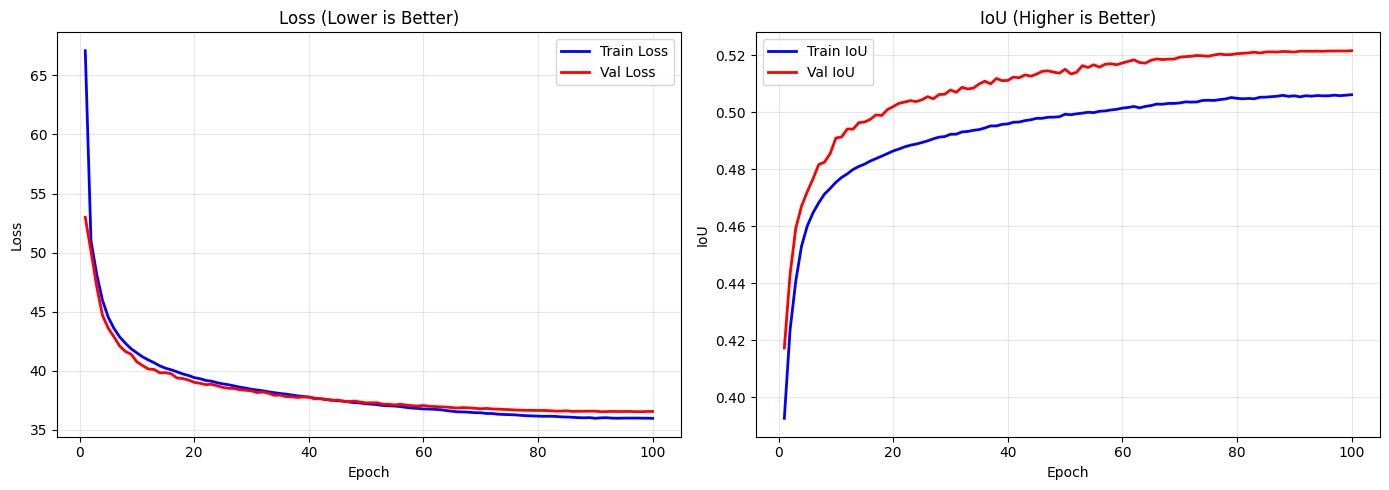


Final Results:
  Train Loss: 35.9591 → Val Loss: 36.5425 (Gap: 1.02x)
  Train IoU: 0.5062 → Val IoU: 0.5216
  Best Val Loss: 36.5193 | Best Val IoU: 0.5216


In [32]:
# Plot training history with IoU
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(train_losses) + 1)

# Loss plot
axes[0].plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss (Lower is Better)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IoU plot
axes[1].plot(epochs_range, train_ious, 'b-', label='Train IoU', linewidth=2)
axes[1].plot(epochs_range, val_ious, 'r-', label='Val IoU', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('IoU (Higher is Better)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\nFinal Results:")
print(f"  Train Loss: {train_losses[-1]:.4f} → Val Loss: {val_losses[-1]:.4f} (Gap: {val_losses[-1]/train_losses[-1]:.2f}x)")
print(f"  Train IoU: {train_ious[-1]:.4f} → Val IoU: {val_ious[-1]:.4f}")
print(f"  Best Val Loss: {best_val_loss:.4f} | Best Val IoU: {best_val_iou:.4f}")

In [28]:
# ============================================
# MODEL DIAGNOSTIC: Capacity vs Training Issue
# ============================================
print("=" * 70)
print("🔍 MODEL PERFORMANCE DIAGNOSTIC")
print("=" * 70)

# Analyze training curves
if len(train_losses) > 0 and len(val_losses) > 0:
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    
    # Calculate gap
    loss_gap = final_val_loss - final_train_loss
    gap_ratio = final_val_loss / (final_train_loss + 1e-6)
    
    print(f"\n📊 Training Statistics:")
    print(f"  Final Train Loss: {final_train_loss:.4f}")
    print(f"  Final Val Loss:   {final_val_loss:.4f}")
    print(f"  Best Train Loss:  {min_train_loss:.4f}")
    print(f"  Best Val Loss:    {min_val_loss:.4f}")
    print(f"  Train-Val Gap:    {loss_gap:.4f} (ratio: {gap_ratio:.2f}x)")
    
    print(f"\n🩺 DIAGNOSIS:")
    
    # Diagnostic rules
    if final_train_loss > 30:  # High training loss
        if gap_ratio < 1.5:
            print("  ⚠️  UNDERFITTING DETECTED (Model Capacity Limited)")
            print("  → Training loss is high AND val loss is similar")
            print("  → Model cannot learn the training data well")
            print("  → SOLUTION: Add more layers/parameters")
            diagnosis = "underfitting"
        else:
            print("  ⚠️  MIXED: High loss + some overfitting")
            diagnosis = "mixed"
    else:  # Low training loss
        if gap_ratio > 2.0:
            print("  ⚠️  OVERFITTING DETECTED (Training Issue)")
            print("  → Training loss is low BUT val loss is much higher")
            print("  → Model memorizes training data, doesn't generalize")
            print("  → SOLUTION: More augmentation, dropout, regularization")
            diagnosis = "overfitting"
        elif gap_ratio > 1.5:
            print("  ⚠️  MILD OVERFITTING")
            print("  → Some gap between train and val")
            print("  → SOLUTION: Add augmentation + early stopping")
            diagnosis = "mild_overfitting"
        else:
            print("  ✅ HEALTHY TRAINING")
            print("  → Train and val losses are close")
            print("  → Model generalizes well")
            diagnosis = "healthy"
    
    # Check if loss plateaued
    if len(train_losses) > 10:
        recent_improvement = train_losses[-10] - train_losses[-1]
        if recent_improvement < 1.0:
            print(f"\n  📉 Loss Plateau: Training loss barely improved in last 10 epochs")
            print(f"     Improvement: {recent_improvement:.4f}")
            if diagnosis == "underfitting":
                print("     → Confirms model capacity is the bottleneck")

print(f"\n" + "=" * 70)
print("📐 MODEL CAPACITY ANALYSIS")
print("=" * 70)

# Model size comparison
total_params = sum(p.numel() for p in model.parameters())
print(f"\nYour Tiny-YOLO: {total_params:,} parameters ({total_params/1e6:.2f}M)")
print(f"\nReference model sizes:")
print(f"  Tiny-YOLO (original):  ~6.9M parameters")
print(f"  YOLOv3-tiny:          ~8.7M parameters")
print(f"  YOLOv4-tiny:          ~6.1M parameters")
print(f"  YOLOv5n (nano):       ~1.9M parameters")
print(f"  YOLOv5s (small):      ~7.2M parameters")
print(f"  YOLOv8n (nano):       ~3.2M parameters")

if total_params < 5e6:
    print(f"\n⚠️  Your model is SMALLER than typical Tiny-YOLO")
    print(f"   This may limit performance on COCO (80 classes)")
elif total_params < 10e6:
    print(f"\n✓ Model size is reasonable for Tiny-YOLO")
else:
    print(f"\n✓ Model has good capacity")

# Expected performance
print(f"\n" + "=" * 70)
print("🎯 EXPECTED PERFORMANCE ON COCO")
print("=" * 70)
print(f"\nTypical mAP@0.5 on COCO val2017:")
print(f"  Tiny-YOLO:    ~23% mAP")
print(f"  YOLOv3-tiny:  ~33% mAP")
print(f"  YOLOv5n:      ~28% mAP")
print(f"  YOLOv5s:      ~37% mAP")
print(f"\nNote: COCO is a HARD dataset with 80 classes and small objects.")
print(f"High loss values are normal during early training.")

# Recommendations
print(f"\n" + "=" * 70)
print("💡 RECOMMENDATIONS")
print("=" * 70)

if 'diagnosis' in dir():
    if diagnosis in ["underfitting", "mixed"]:
        print("""
FOR UNDERFITTING (Capacity Limited):
1. Add more convolutional layers (deeper network)
2. Increase filter counts (wider network)  
3. Add skip connections (like ResNet)
4. Consider using YOLOv5-small architecture instead

I can create an IMPROVED model with more capacity if you want.
        """)
    elif diagnosis in ["overfitting", "mild_overfitting"]:
        print("""
FOR OVERFITTING (Training Issue):
1. ✓ Already added: Data augmentation, dropout
2. Try: Reduce learning rate further
3. Try: Increase weight decay (L2 regularization)
4. Try: Use more training data
5. Try: Label smoothing for classification
        """)
    else:
        print("""
MODEL IS TRAINING WELL:
- Continue training or use current best checkpoint
- Evaluate mAP to measure actual detection performance
        """)

print("\nWould you like me to:")
print("  A) Create a BIGGER model with more layers (for underfitting)")
print("  B) Further tune training hyperparameters (for overfitting)")
print("  C) Add mAP evaluation to measure actual detection quality")

🔍 MODEL PERFORMANCE DIAGNOSTIC

📊 Training Statistics:
  Final Train Loss: 35.9591
  Final Val Loss:   36.5425
  Best Train Loss:  35.9591
  Best Val Loss:    36.5193
  Train-Val Gap:    0.5834 (ratio: 1.02x)

🩺 DIAGNOSIS:
  ⚠️  UNDERFITTING DETECTED (Model Capacity Limited)
  → Training loss is high AND val loss is similar
  → Model cannot learn the training data well
  → SOLUTION: Add more layers/parameters

  📉 Loss Plateau: Training loss barely improved in last 10 epochs
     Improvement: 0.0432
     → Confirms model capacity is the bottleneck

📐 MODEL CAPACITY ANALYSIS

Your Tiny-YOLO: 7,955,769 parameters (7.96M)

Reference model sizes:
  Tiny-YOLO (original):  ~6.9M parameters
  YOLOv3-tiny:          ~8.7M parameters
  YOLOv4-tiny:          ~6.1M parameters
  YOLOv5n (nano):       ~1.9M parameters
  YOLOv5s (small):      ~7.2M parameters
  YOLOv8n (nano):       ~3.2M parameters

✓ Model size is reasonable for Tiny-YOLO

🎯 EXPECTED PERFORMANCE ON COCO

Typical mAP@0.5 on COCO val

## Inference and Visualization

In [29]:
def decode_predictions(predictions, anchors, num_classes, conf_threshold=0.5, nms_threshold=0.4):
    """
    Decode YOLO predictions to bounding boxes
    
    predictions: (batch, num_anchors*(5+num_classes), grid_size, grid_size)
    Returns: List of detections for each image
    """
    batch_size = predictions.size(0)
    grid_size = predictions.size(2)
    num_anchors = anchors.size(0)
    
    # Reshape predictions
    predictions = predictions.view(batch_size, num_anchors, 5 + num_classes, grid_size, grid_size)
    predictions = predictions.permute(0, 3, 4, 1, 2).contiguous()  # (batch, grid, grid, anchors, 5+classes)
    
    all_detections = []
    
    for b in range(batch_size):
        detections = []
        
        for cy in range(grid_size):
            for cx in range(grid_size):
                for a in range(num_anchors):
                    pred = predictions[b, cy, cx, a]
                    
                    # Get confidence
                    conf = torch.sigmoid(pred[4]).item()
                    
                    if conf < conf_threshold:
                        continue
                    
                    # Get class probabilities
                    class_probs = torch.sigmoid(pred[5:])
                    class_score, class_idx = class_probs.max(0)
                    
                    # Final score
                    score = conf * class_score.item()
                    
                    if score < conf_threshold:
                        continue
                    
                    # Decode bounding box
                    tx, ty = torch.sigmoid(pred[0]).item(), torch.sigmoid(pred[1]).item()
                    tw, th = pred[2].item(), pred[3].item()
                    
                    # Convert to absolute coordinates
                    bx = (cx + tx) / grid_size
                    by = (cy + ty) / grid_size
                    bw = anchors[a, 0].item() * np.exp(tw) / grid_size
                    bh = anchors[a, 1].item() * np.exp(th) / grid_size
                    
                    # Convert to corner format (x1, y1, x2, y2)
                    x1 = max(0, bx - bw / 2)
                    y1 = max(0, by - bh / 2)
                    x2 = min(1, bx + bw / 2)
                    y2 = min(1, by + bh / 2)
                    
                    detections.append({
                        'bbox': [x1, y1, x2, y2],
                        'score': score,
                        'class': class_idx.item()
                    })
        
        # Apply NMS
        if len(detections) > 0:
            detections = apply_nms(detections, nms_threshold)
        
        all_detections.append(detections)
    
    return all_detections


def apply_nms(detections, threshold):
    """Apply Non-Maximum Suppression"""
    if len(detections) == 0:
        return []
    
    # Sort by score
    detections = sorted(detections, key=lambda x: x['score'], reverse=True)
    
    keep = []
    while len(detections) > 0:
        best = detections.pop(0)
        keep.append(best)
        
        detections = [d for d in detections if 
                      d['class'] != best['class'] or 
                      compute_iou(best['bbox'], d['bbox']) < threshold]
    
    return keep


def compute_iou(box1, box2):
    """Compute IoU between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return inter_area / (box1_area + box2_area - inter_area + 1e-6)


def visualize_detections(image, detections, class_names):
    """Visualize detections on image"""
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Denormalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = image.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    colors = plt.cm.hsv(np.linspace(0, 1, len(class_names)))
    
    for det in detections:
        bbox = det['bbox']
        class_idx = det['class']
        score = det['score']
        
        # Scale bbox to image size
        h, w = img.shape[:2]
        x1, y1 = bbox[0] * w, bbox[1] * h
        x2, y2 = bbox[2] * w, bbox[3] * h
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor=colors[class_idx], facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        label = f'{class_names[class_idx]}: {score:.2f}'
        ax.text(x1, y1 - 5, label, color='white', fontsize=10,
                bbox=dict(boxstyle='round', facecolor=colors[class_idx], alpha=0.8))
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Inference functions defined")

Inference functions defined


Loaded best model from epoch 91
Validation loss: 36.5193

Image 0: Found 9 objects


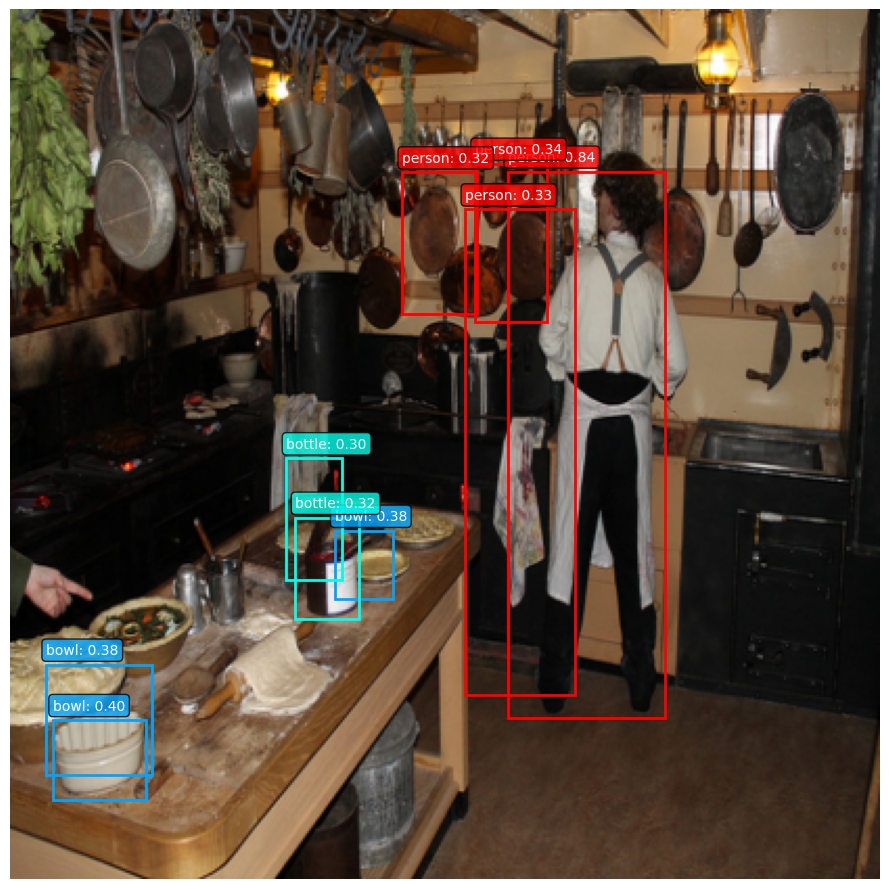


Image 10: Found 13 objects


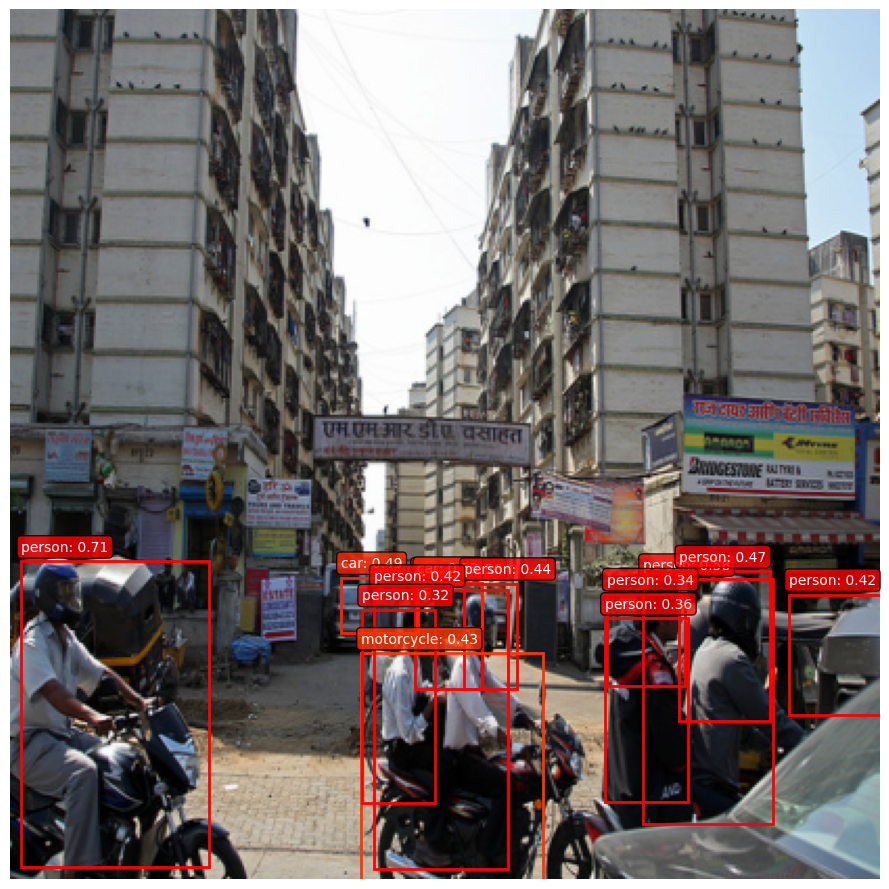


Image 20: Found 3 objects


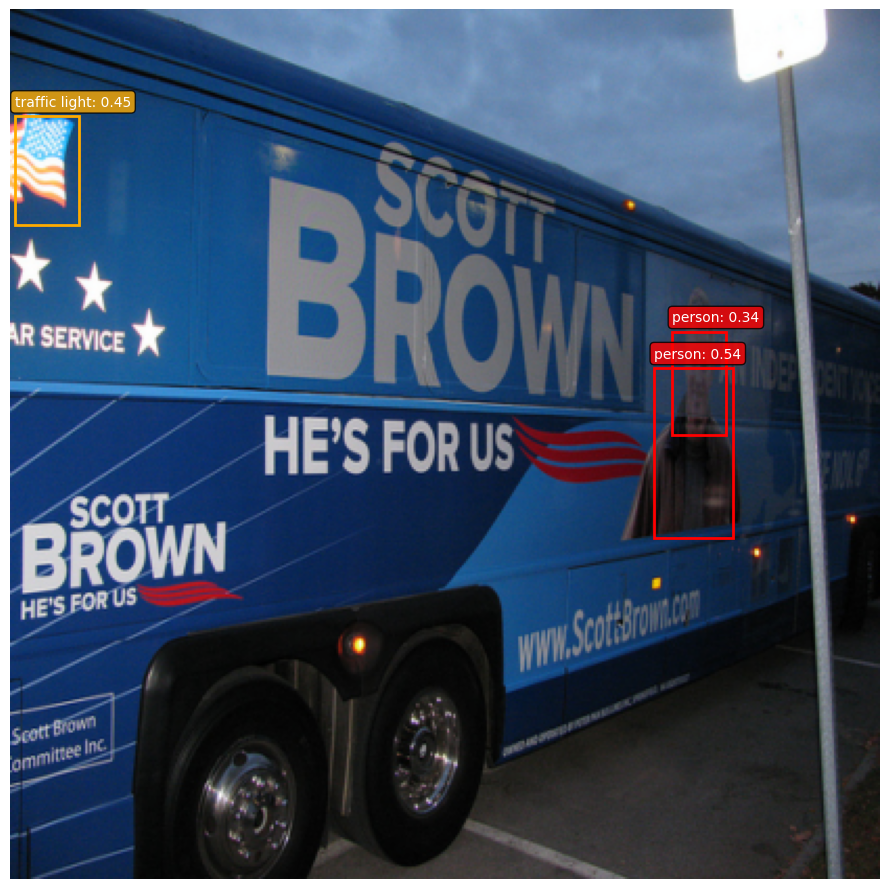


Image 30: Found 6 objects


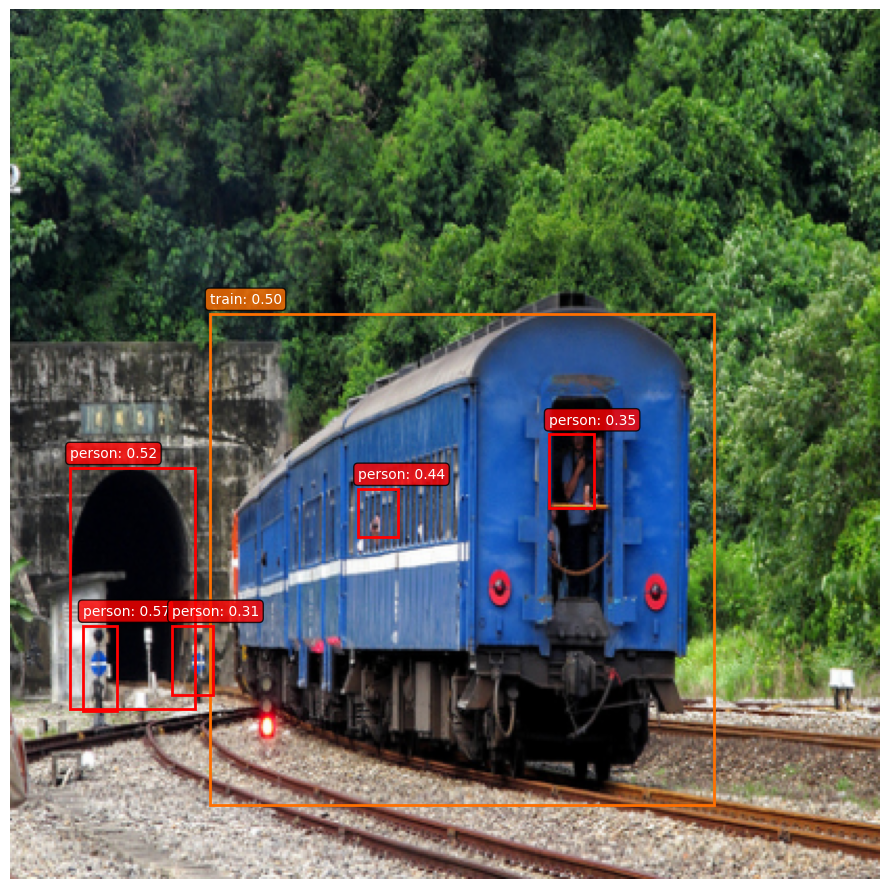


Image 40: Found 0 objects


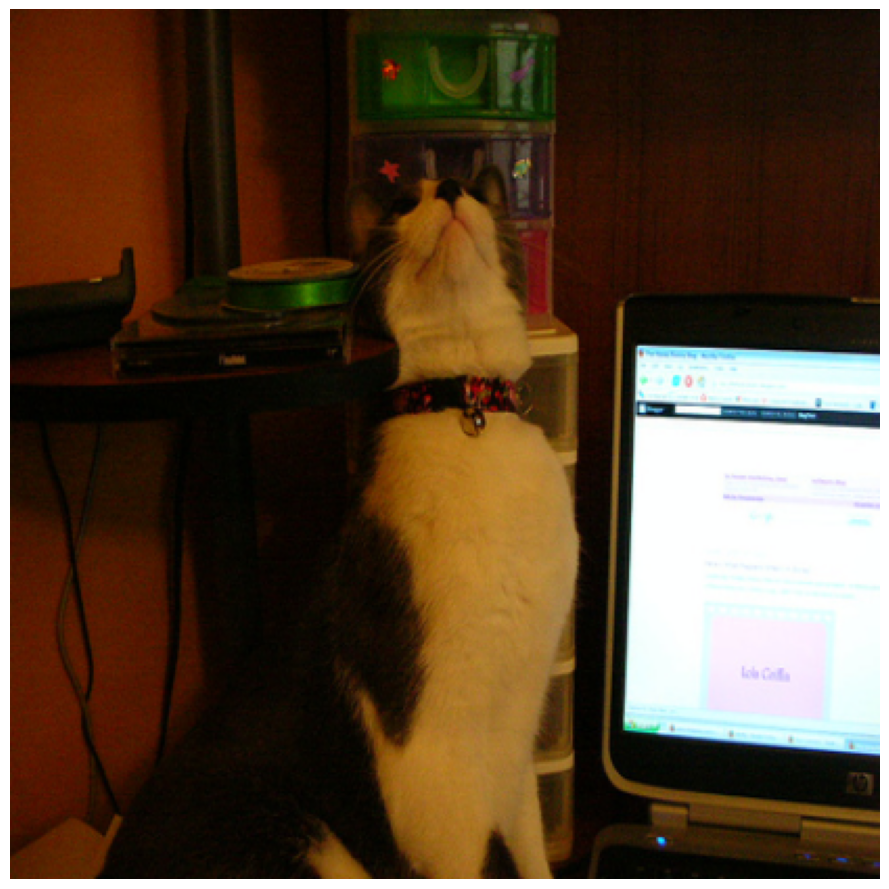

In [30]:
# Load best model and run inference on validation images
checkpoint = torch.load('tiny_yolo_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")

# Get sample images from validation set
sample_indices = [0, 10, 20, 30, 40]

for idx in sample_indices:
    if idx >= len(val_dataset):
        continue
    
    # Handle both regular dataset and Subset (from random_split)
    if hasattr(val_dataset, 'dataset'):
        # It's a Subset from random_split
        image, _ = val_dataset.dataset[val_dataset.indices[idx]]
    else:
        image, _ = val_dataset[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    detections = decode_predictions(predictions, ANCHORS, NUM_CLASSES, 
                                    conf_threshold=0.3, nms_threshold=0.4)
    
    print(f"\nImage {idx}: Found {len(detections[0])} objects")
    visualize_detections(image, detections[0], COCO_CLASSES)

## Model Summary

In [31]:
# Print detailed model architecture
print("=" * 70)
print("TINY-YOLO ARCHITECTURE SUMMARY")
print("=" * 70)
print(f"\n{'Layer':<30} {'Output Shape':<25} {'Parameters':>12}")
print("-" * 70)

def count_parameters(module):
    return sum(p.numel() for p in module.parameters())

# Track feature map sizes
test_input = torch.randn(1, 3, 416, 416).to(device)
x = test_input

layers_info = [
    ('Input', test_input.shape, 0),
]

# Layer by layer forward pass for shape tracking
with torch.no_grad():
    x = model.conv1(x)
    layers_info.append(('Conv1 (3→16, 3x3)', x.shape, count_parameters(model.conv1)))
    x = model.pool1(x)
    layers_info.append(('MaxPool1 (2x2)', x.shape, 0))
    
    x = model.conv2(x)
    layers_info.append(('Conv2 (16→32, 3x3)', x.shape, count_parameters(model.conv2)))
    x = model.pool2(x)
    layers_info.append(('MaxPool2 (2x2)', x.shape, 0))
    
    x = model.conv3(x)
    layers_info.append(('Conv3 (32→64, 3x3)', x.shape, count_parameters(model.conv3)))
    x = model.pool3(x)
    layers_info.append(('MaxPool3 (2x2)', x.shape, 0))
    
    x = model.conv4(x)
    layers_info.append(('Conv4 (64→128, 3x3)', x.shape, count_parameters(model.conv4)))
    x = model.pool4(x)
    layers_info.append(('MaxPool4 (2x2)', x.shape, 0))
    
    x = model.conv5(x)
    layers_info.append(('Conv5 (128→256, 3x3)', x.shape, count_parameters(model.conv5)))
    x = model.pool5(x)
    layers_info.append(('MaxPool5 (2x2)', x.shape, 0))
    
    x = model.conv6(x)
    layers_info.append(('Conv6 (256→512, 3x3)', x.shape, count_parameters(model.conv6)))
    x = model.pool6(x)
    layers_info.append(('MaxPool6 (2x2, pad)', x.shape, 0))
    
    x = model.conv7(x)
    layers_info.append(('Conv7 (512→1024, 3x3)', x.shape, count_parameters(model.conv7)))
    
    x = model.conv8(x)
    layers_info.append(('Conv8 (1024→256, 1x1)', x.shape, count_parameters(model.conv8)))
    
    x = model.conv9(x)
    layers_info.append(('Conv9 (256→512, 3x3)', x.shape, count_parameters(model.conv9)))
    
    x = model.detection(x)
    layers_info.append(('Detection (512→125, 1x1)', x.shape, count_parameters(model.detection)))

for name, shape, params in layers_info:
    shape_str = str(tuple(shape.tolist()) if hasattr(shape, 'tolist') else shape)
    print(f"{name:<30} {shape_str:<25} {params:>12,}")

print("-" * 70)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{'Total Parameters:':<55} {total_params:>12,}")
print(f"{'Trainable Parameters:':<55} {trainable_params:>12,}")
print(f"{'Model Size (MB):':<55} {total_params * 4 / 1024**2:>12.2f}")
print("=" * 70)

TINY-YOLO ARCHITECTURE SUMMARY

Layer                          Output Shape                Parameters
----------------------------------------------------------------------
Input                          torch.Size([1, 3, 416, 416])            0
Conv1 (3→16, 3x3)              torch.Size([1, 16, 416, 416])          464
MaxPool1 (2x2)                 torch.Size([1, 16, 208, 208])            0
Conv2 (16→32, 3x3)             torch.Size([1, 32, 208, 208])        4,672
MaxPool2 (2x2)                 torch.Size([1, 32, 104, 104])            0
Conv3 (32→64, 3x3)             torch.Size([1, 64, 104, 104])       18,560
MaxPool3 (2x2)                 torch.Size([1, 64, 52, 52])            0
Conv4 (64→128, 3x3)            torch.Size([1, 128, 52, 52])       73,984
MaxPool4 (2x2)                 torch.Size([1, 128, 26, 26])            0
Conv5 (128→256, 3x3)           torch.Size([1, 256, 26, 26])      295,424
MaxPool5 (2x2)                 torch.Size([1, 256, 13, 13])            0
Conv6 (256→512, 3x3)